# Deep learning with Python Francois Chollet 2018

Train a convolution network to classify digits using the MNIST dataset with augmenting the training set using image generation and averaging the result over two identical models.

## Load the train and test sets

We start by loading the train and test sets consisting of 60000 and 10000 28x28 pixel grayscale images. Each pixel has a value between 0 and 255 stored in numpy uint8.

In [22]:
from keras import datasets

(orig_train_images, orig_train_labels), (orig_test_images, orig_test_labels) = datasets.mnist.load_data()

print(f'The shape of the training set is: {orig_train_images.shape}')
print(f'The shape of the test set is: {orig_test_images.shape}')
print(f'The data type of the training set is: {orig_train_images.dtype}')
print(f'The data type of the test set is: {orig_test_images.dtype}')

The shape of the training set is: (60000, 28, 28)
The shape of the test set is: (10000, 28, 28)
The data type of the training set is: uint8
The data type of the test set is: uint8


## Example images

Let's plot first images from the training and test sets with their associated labels to see what they look like.

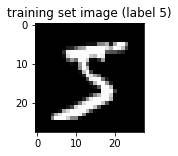

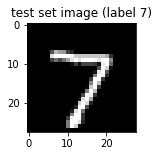

In [23]:
%matplotlib inline

def show_image(title, images, labels):
    from matplotlib import pyplot
    pyplot.rcParams["figure.figsize"] = (2,2)
    pyplot.title(f'{title} set image (label {labels[0]})')
    pyplot.imshow(images[0], cmap="gray")
    pyplot.show()

show_image('training', orig_train_images, orig_train_labels)
show_image('test', orig_test_images, orig_test_labels)

## Shape the training and test set images

We need to shape the images to be suitable for training the network. Images are converted from 28x28 2D tensors with 0-255 numpy uint8s to 28*28 1D tensors with 0-1 numpy float32s. 

In [24]:
train_images = orig_train_images.reshape((orig_train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = orig_test_images.reshape((orig_test_images.shape[0], 28, 28, 1)).astype('float32') / 255

print(f'The shape of the original training set: {orig_train_images.shape}')
print(f'The shape of the actual training set: {train_images.shape}')
print(f'The shape of the original test set: {orig_test_images.shape}')
print(f'The shape of the actual test set: {test_images.shape}')
print(f'The data type of the original training set: {orig_train_images.dtype}')
print(f'The data type of the actual training set: {train_images.dtype}')
print(f'The data type of the original test set: {orig_test_images.dtype}')
print(f'The data type of the actual test set: {test_images.dtype}')

The shape of the original training set: (60000, 28, 28)
The shape of the actual training set: (60000, 28, 28, 1)
The shape of the original test set: (10000, 28, 28)
The shape of the actual test set: (10000, 28, 28, 1)
The data type of the original training set: uint8
The data type of the actual training set: float32
The data type of the original test set: uint8
The data type of the actual test set: float32


## Augment the training set by generating additional images

In [25]:
from keras.preprocessing.image import ImageDataGenerator

gen_train_images = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2)

## Shape the training and test set labels

We need to also shape the labels to be suitable for training the network. Scalar labels are replaced with 1D binary tensors with value 0 or 1 for each label. If the value is 1 then the image is associated with that label.

In [27]:
from keras.utils import to_categorical

train_labels = to_categorical(orig_train_labels)
test_labels = to_categorical(orig_test_labels)

print(f'The shape of the original train labels: {orig_train_labels.shape}')
print(f'The shape of the actual train labels: {train_labels.shape}')
print(f'The shape of the original test labels: {orig_test_labels.shape}')
print(f'The shape of the actual test labels: {test_labels.shape}')
print(f'First original train label: {orig_train_labels[0]}')
print(f'First actual train label: {train_labels[0]}')
print(f'First original test label: {orig_test_labels[0]}')
print(f'First actual test label: {test_labels[0]}')

The shape of the original train labels: (60000,)
The shape of the actual train labels: (60000, 10)
The shape of the original test labels: (10000,)
The shape of the actual test labels: (10000, 10)
First original train label: 5
First actual train label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
First original test label: 7
First actual test label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Define and train the network

We use a sequential network. The input shape for the first layer must corresponds to the shape of the images (28*28 1D tensors). Once the network layers have been created we define the optimizer and loss function using the compile function. Finally, we train the network using the fit function and print out the loss and accuracy of the model.

In [47]:
import math
from keras import models
from keras import layers
from keras import callbacks

epochs = 10

def create_model():
    network = models.Sequential()
    network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    network.add(layers.MaxPooling2D(2, 2))
    network.add(layers.Conv2D(64, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D(2, 2))
    network.add(layers.Conv2D(64, (3, 3), activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(64, activation='relu'))
    # network.add(layers.Dense(10, activation='softmax'))
    return network

model1 = create_model()
model2 = create_model()

merge = layers.Average()([model1.output, model2.output])
merge = layers.Dense(10, activation='softmax')(merge)

network = models.Model([model1.input, model2.input], merge)
network.summary()

network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
                       
history = network.fit_generator(gen_train_images.flow([train_images, train_images], train_labels, batch_size=32), 
    steps_per_epoch=len(train_images) / 32, 
    epochs=epochs, 
    validation_data=([test_images, test_images], test_labels),
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

loss, accuracy = network.evaluate([test_images, test_images], test_labels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_139_input (InputLayer)   (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_142_input (InputLayer)   (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 26, 26, 32)   320         conv2d_139_input[0][0]           
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 26, 26, 32)   320         conv2d_142_input[0][0]           
__________________________________________________________________________________________________
max_poolin

## Model overfitting

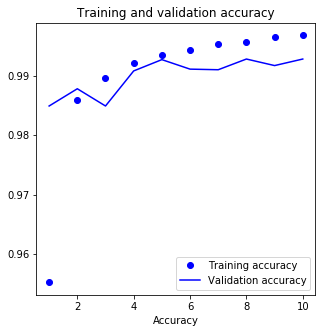

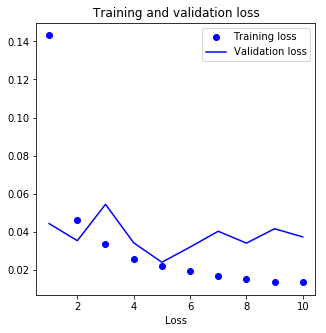

In [49]:
from matplotlib import pyplot

pyplot.rcParams["figure.figsize"] = (5,5)

train_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epocs = range(1, len(train_loss) + 1)

pyplot.plot(epocs, train_accuracy, 'bo', label='Training accuracy')
pyplot.plot(epocs, validation_accuracy, 'b', label='Validation accuracy')
pyplot.title('Training and validation accuracy')
pyplot.xlabel('Epochs')
pyplot.xlabel('Accuracy')
pyplot.legend()
pyplot.show()

pyplot.plot(epocs, train_loss, 'bo', label='Training loss')
pyplot.plot(epocs, validation_loss, 'b', label='Validation loss')
pyplot.title('Training and validation loss')
pyplot.xlabel('Epochs')
pyplot.xlabel('Loss')
pyplot.legend()
pyplot.show()


## Invalid prediction counts

Lets show how may times each digit in the test set was incorrectly classified as one of the other digits.

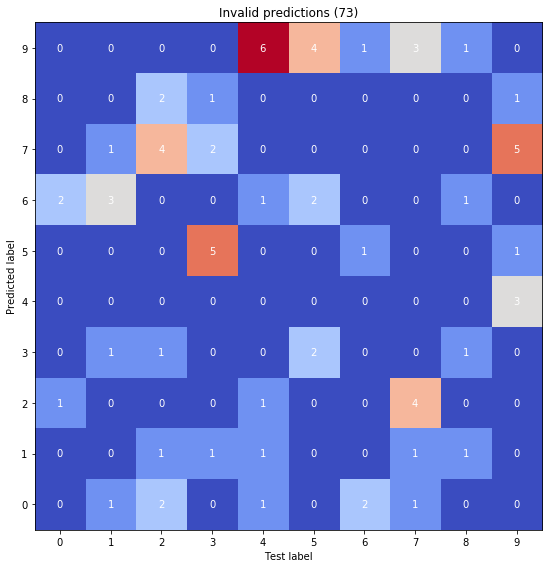

In [52]:
import numpy
from matplotlib import pyplot

predicted_labels = network.predict([test_images, test_images])

## Find invalid predictions.

invalid_prediction = []
invalid_prediction_cnt = numpy.zeros((10,10), dtype=int)

for i,v in enumerate(predicted_labels):
    test_label = numpy.where(test_labels[i] == numpy.amax(test_labels[i]))[0].item(0)
    predicted_test_label = numpy.where(predicted_labels[i] == numpy.amax(predicted_labels[i]))[0].item(0)
    if test_label != predicted_test_label:
        invalid_prediction_cnt[test_label][predicted_test_label] += 1        
        invalid_prediction.append((i, test_label, predicted_test_label))
        
total_invalid_prediction_cnt = numpy.sum(invalid_prediction_cnt)        

## Plot invalid prediction counts.

x_test_labels = numpy.arange(10)
y_predicted_labels = numpy.arange(10)

fig, ax = pyplot.subplots(figsize=(8,8))

ax.imshow(invalid_prediction_cnt, cmap="coolwarm")
ax.set_title(f'Invalid predictions ({total_invalid_prediction_cnt})')
ax.set_xticks(x_test_labels)
ax.set_yticks(y_predicted_labels)
ax.set_xlabel('Test label')
ax.set_ylabel('Predicted label')
ax.invert_yaxis()

for i in range(len(x_test_labels)):
    for j in range(len(y_predicted_labels)):
        # Show number of invalid predictions.
        text = ax.text(j, i, invalid_prediction_cnt[i, j],
                       ha="center", va="center", color="w")

fig.tight_layout()
pyplot.show()


## Invalid predictions

Finally lets show all the images in the test set that were categorized incorrectly.

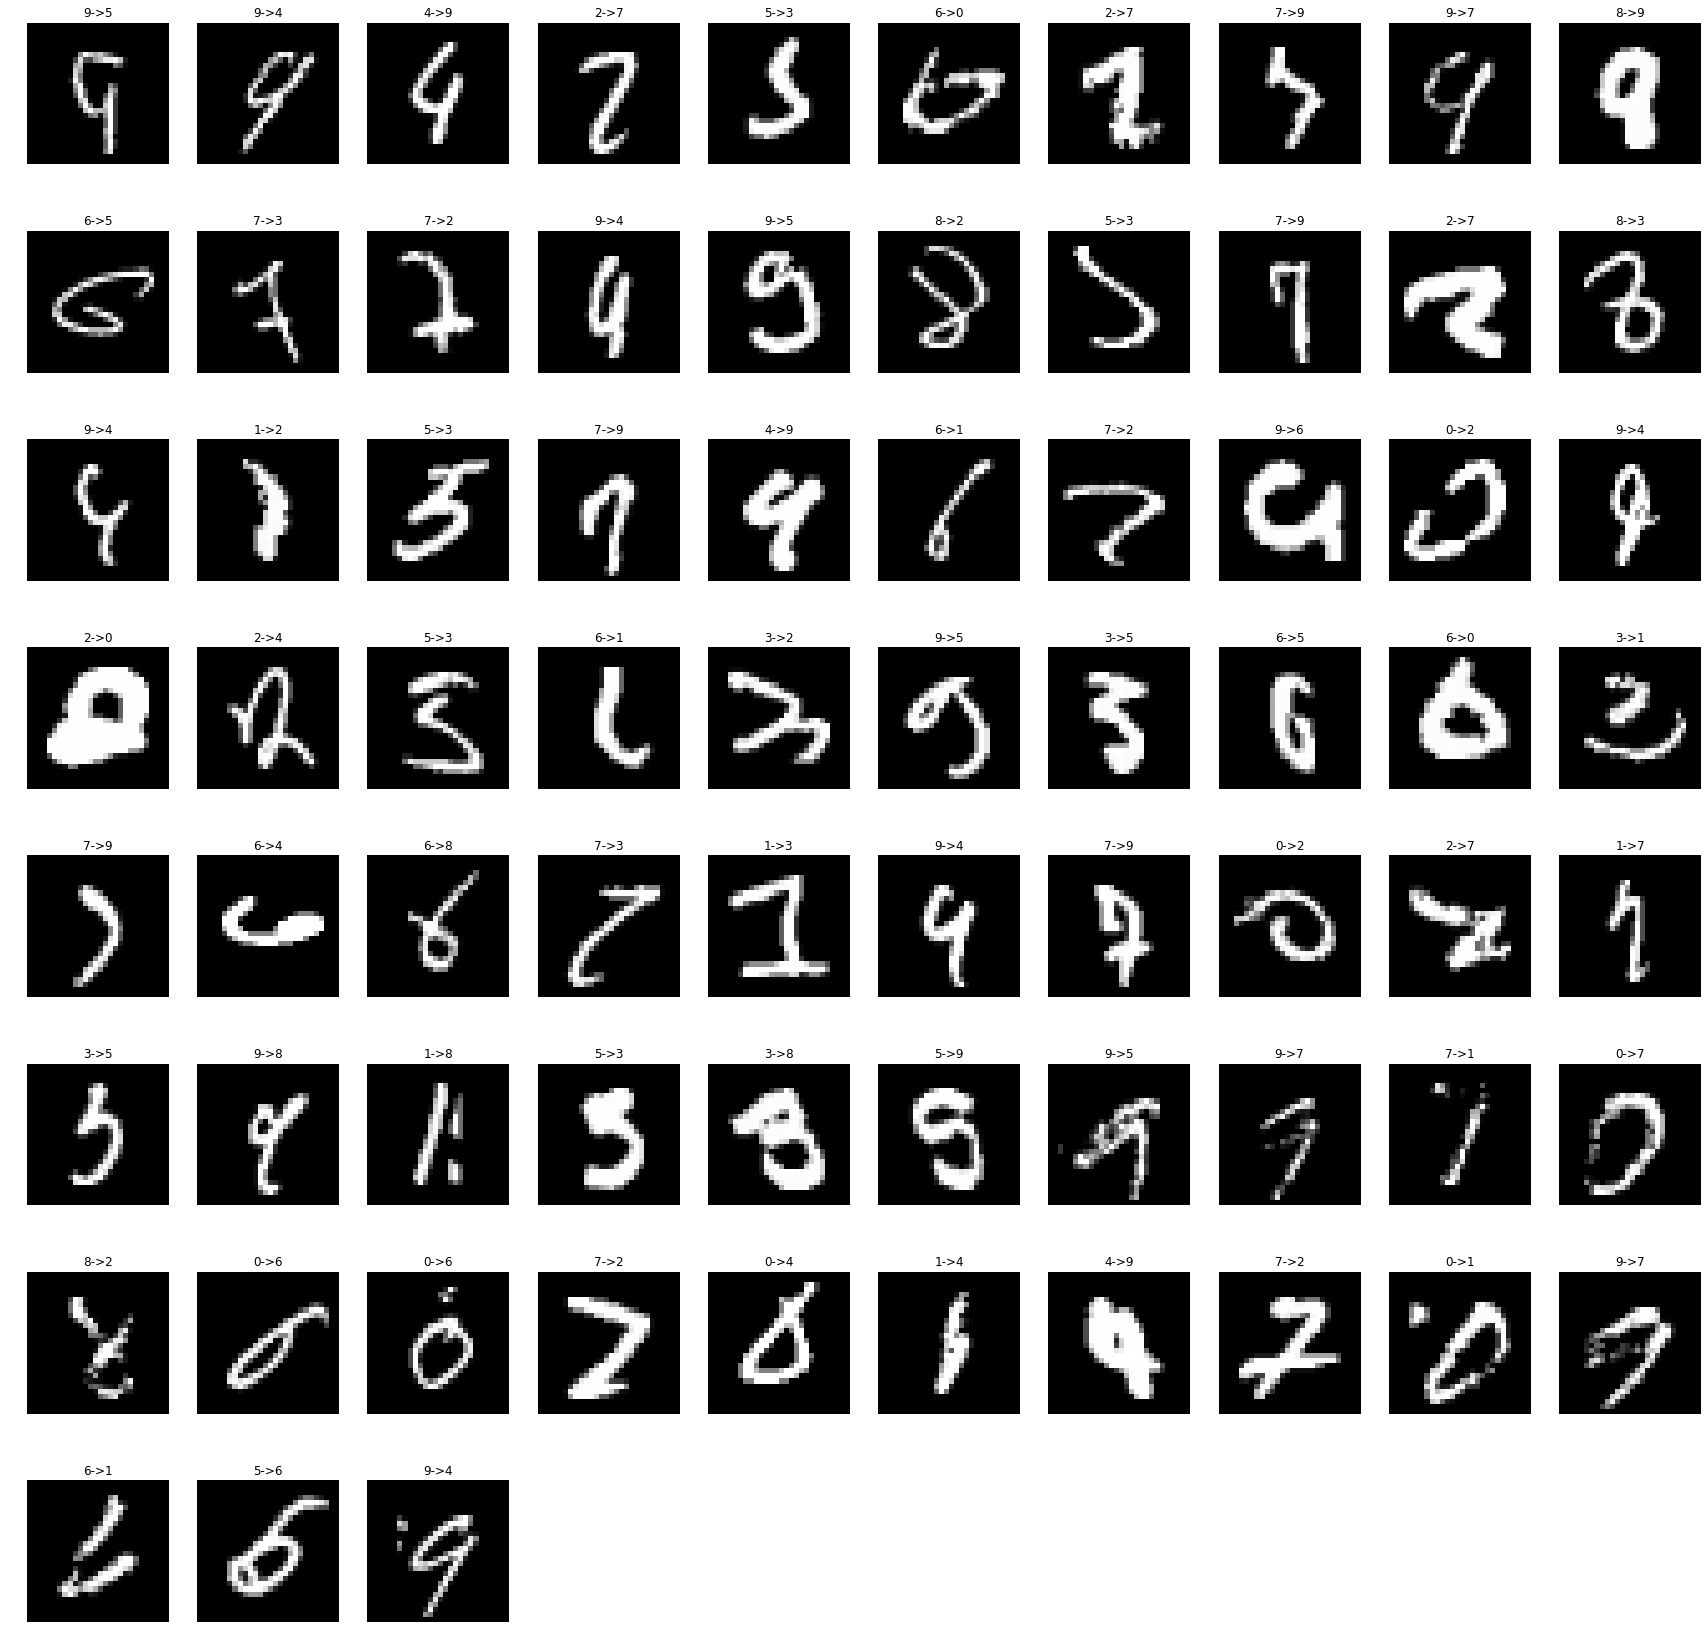

In [53]:
pyplot.rcParams["figure.figsize"] = (30,30)

ncols = 10
nrows = math.ceil(total_invalid_prediction_cnt / ncols)

for i in range(total_invalid_prediction_cnt):
    idx, test_label, predicted_test_label = invalid_prediction[i]
    row = math.floor(i / ncols)
    col = i % ncols
    ax = pyplot.subplot2grid((nrows,ncols),(row,col))
    ax.axis('off')
    ax.set_title(f'{test_label}->{predicted_test_label}')
    ax.imshow(orig_test_images[idx], cmap="gray")
pyplot.show()
